#Importing essential Libraries

In [67]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
image_path = '/content/drive/MyDrive/DL/Datasets/MNIST/testSet'

image_data = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing  
  new_image = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
  image_data.append(new_image)
  
images = np.array(image_data)
print("Size of image array: ", images.shape)

Loading Training Images...
Size of image array:  (28000, 28, 28)


##Visualizing some images

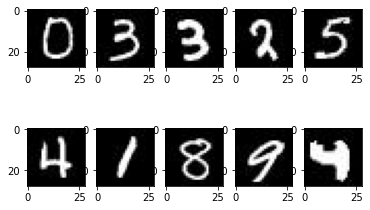

In [70]:
plt.figure(1)
plt.subplot(2,5,1)
plt.imshow(images[15], cmap= 'gray')
plt.subplot(2,5,2)
plt.imshow(images[16], cmap= 'gray')
plt.subplot(2,5,3)
plt.imshow(images[100], cmap= 'gray')
plt.subplot(2,5,4)
plt.imshow(images[200], cmap= 'gray')
plt.subplot(2,5,5)
plt.imshow(images[300], cmap= 'gray')
plt.subplot(2,5,6)
plt.imshow(images[400], cmap= 'gray')
plt.subplot(2,5,7)
plt.imshow(images[500], cmap= 'gray')
plt.subplot(2,5,8)
plt.imshow(images[600], cmap= 'gray')
plt.subplot(2,5,9)
plt.imshow(images[700], cmap= 'gray')
plt.subplot(2,5,10)
plt.imshow(images[800], cmap= 'gray')
plt.show()

## Doing some preprocessing

In [71]:
#Checking if gpu is available
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [72]:
images = np.array(images, dtype= np.float32)
images = images/ 255.0

In [73]:
#Moving images to DEVICE
images = torch.tensor(images, device= DEVICE)
print(images.dtype)

torch.float32


In [74]:
images_vec = images.reshape(images.shape[0], -1)

In [75]:
print("shape of image after flattening them: ", images_vec.shape)

shape of image after flattening them:  torch.Size([28000, 784])


#Creating Network Architecture

credits: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

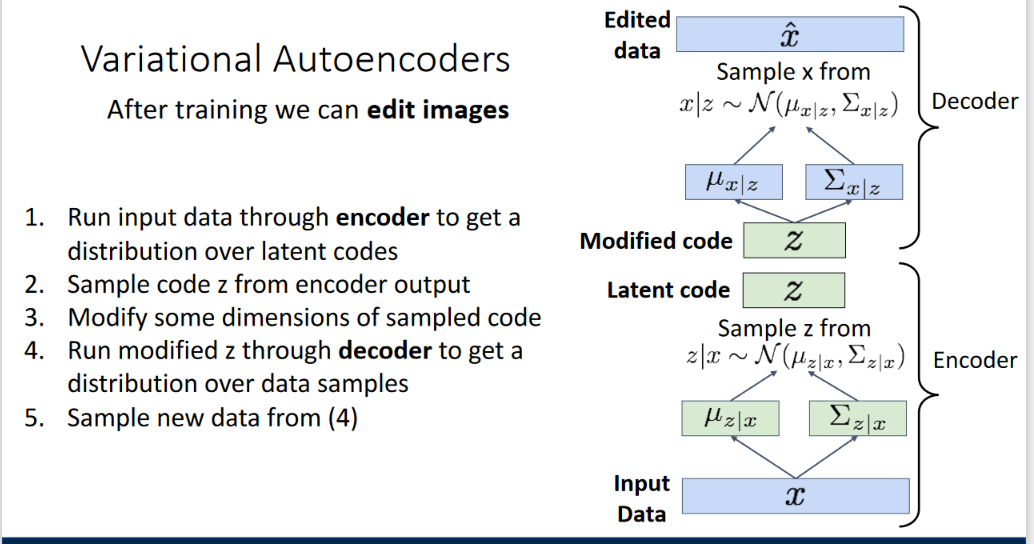

In [76]:
class Variational_Autoencoders(nn.Module):

  def __init__(self,input_dims, hidden_dims, z_shape ):     #Features is the dimension of Height and Width of the image
    super(Variational_Autoencoders, self).__init__()

    #Encoder Network
    self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
        )
    
    #sapearte fully connected layer for mean. we will sample from mean and covariance to form the vector z which will go as input to decoder neywork
    self.mean_layer = nn.Linear(hidden_dims, z_shape)

    #sapearte fully connected layer for covariance
    self.log_covariance_layer = nn.Linear(hidden_dims, z_shape)

    #Decoder Network
    self.decoder = nn.Sequential(
            nn.Linear(z_shape, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, input_dims),
            nn.Sigmoid(),                           #we use sigmoid when we use binary cross entropy loss
            #nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )
    
  def forward(self, input):   #input has shape(N, 784)

    #Passing through encoder network:
    out = self.encoder(input)

    out_mean = self.mean_layer(out)

    out_logcov = self.log_covariance_layer(out)

    #sampling from normal distribution with mean= out_mean and log covariance = out_logcov

    sigma = torch.sqrt(torch.exp(out_logcov))
    z = sigma * torch.randn_like(out_mean) + out_mean

    #Passing through decoder network:
    out = self.decoder(z)
  
    return out, out_mean, out_logcov



In [77]:
vae = Variational_Autoencoders(input_dims = images_vec.shape[1], hidden_dims = 500, z_shape = 20).to(device= DEVICE)

In [78]:
#Doing a forward pass through the network:
out, a, b = vae(images_vec[0:5])

In [79]:
out.shape

torch.Size([5, 784])

#Model Training:

In [80]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)        #update the weights of the network vae
loss_type = nn.BCELoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 2000, gamma = 0.5)  

In [81]:
#Model Training
loss_graph = []
num_epochs = 20000
num_train = images_vec.shape[0]
batch_size = 200
vae.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images_vec[random_no]
  
  optimizer.zero_grad()
  y_pred, out_mean, out_logcov = vae(x_batch)

  y1 = nn.functional.binary_cross_entropy(y_pred, x_batch, reduction='sum')

  y1_ = 1 + out_logcov - out_mean**2 - torch.exp(out_logcov)
  y1_ = -0.5 * y1_.sum()
  loss = y1 + y1_
  loss /= out_mean.shape[0]
  loss.backward()
  optimizer.step()

  #schedular step
  #step_lr.step()

  loss_graph.append(loss.cpu().item())
  if i%200==0:
    print("Epoch: ", i+1, ", loss is: ", loss.cpu().item())
    #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Epoch:  1 , loss is:  543.4957275390625
Epoch:  201 , loss is:  214.4465789794922
Epoch:  401 , loss is:  203.63973999023438
Epoch:  601 , loss is:  203.8512725830078
Epoch:  801 , loss is:  199.5520782470703
Epoch:  1001 , loss is:  189.1752471923828
Epoch:  1201 , loss is:  182.39315795898438
Epoch:  1401 , loss is:  172.80426025390625
Epoch:  1601 , loss is:  164.5390625
Epoch:  1801 , loss is:  166.87710571289062
Epoch:  2001 , loss is:  167.7777862548828
Epoch:  2201 , loss is:  161.43072509765625
Epoch:  2401 , loss is:  155.00254821777344
Epoch:  2601 , loss is:  156.4949188232422
Epoch:  2801 , loss is:  150.1717987060547
Epoch:  3001 , loss is:  151.8649444580078
Epoch:  3201 , loss is:  154.9720001220703
Epoch:  3401 , loss is:  153.50399780273438
Epoch:  3601 , loss is:  146.00497436523438
Epoch:  3801 , loss is:  155.22352600097656
Epoch:  4001 , loss is:  147.01332092285156
Epoch:  4201 , loss is:  150.9198760986328
Epoch:  4401 , loss is:  143.9308319091797
Epoch:  4601 ,

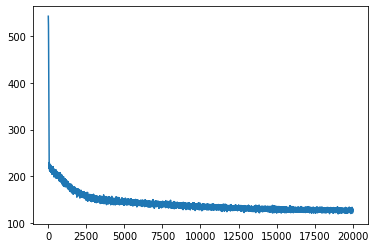

In [82]:
#Loss Curve
#Loss Graph
plt.plot(loss_graph)
plt.show()

In [83]:
vae.eval()
out, a, b = vae(images_vec[0:5])

Actual output: 


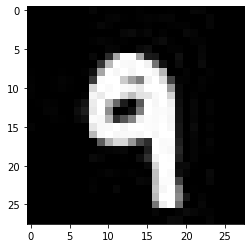

Output from the model: 


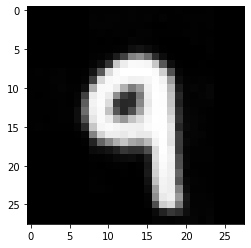

In [84]:
print("Actual output: ")
plt.imshow(images[3].cpu().numpy(), cmap= 'gray')
plt.show()

print("Output from the model: ")
plt.imshow(out[3].reshape(28,28).detach().cpu().numpy(), cmap= 'gray')
plt.show()

we can see that the model is able to replicate the input so now we can use the vector z (sample from mean and logcov) to produce different outputs

In [85]:
def generate_images(input):
  out = vae.decoder(input)
  return out

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


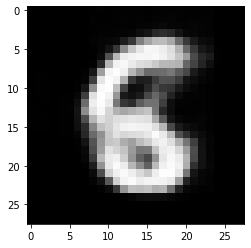

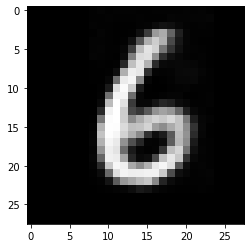

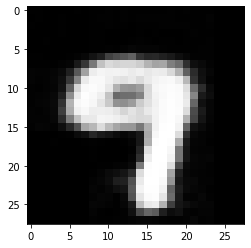

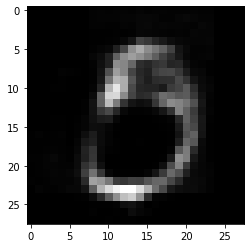

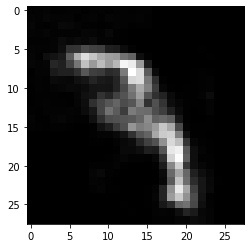

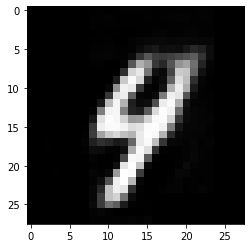

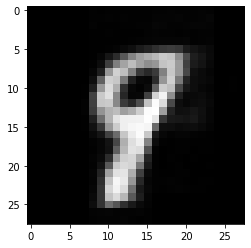

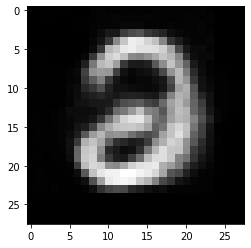

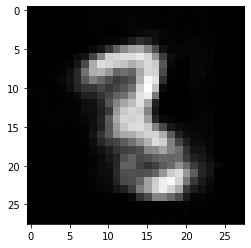

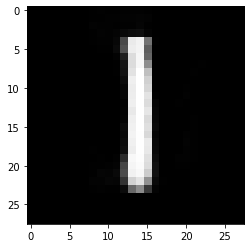

In [86]:
z = torch.randn(10, 20)
z = torch.tensor(z, device = DEVICE, dtype = torch.float32)

for i in range(z.shape[0]):
  img_out = generate_images(z)
  plt.imshow(img_out[i].reshape(28,28).detach().cpu().numpy(), cmap= 'gray')
  plt.show()
